In [2]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from scipy import special
from scipy.interpolate import CubicSpline
matplotlib.rc('text', usetex = True)


# %run Window_Functions.ipynb
# %run Cosmology.ipynb

# Construct Integrand

In [34]:
# redshift list of axioncCAMB runs
zlist = np.linspace(0,4.5,301)
# power spectrum arrays with reversed z-dimension
# axionCAMB outputs redshift from high to low -- converted here to low to high
k = np.reshape(np.load('../data2/k.npy')[:,:,:,::-1],(5,11,9,1,1,len(zlist),660))
pk = np.reshape(np.load('../data2/pk.npy')[:,:,:,::-1],(5,11,9,1,1,len(zlist),660))
# dimensionless power spectrum
pk_dimless = (pk*np.power(k,3.0))/(2.0*np.square(np.pi))
# angular diameter distance
da = np.reshape(d_a(zlist),(1,1,1,1,1,len(zlist),1))
# hubble constant
hz = np.reshape(h(zlist),(1,1,1,1,1,len(zlist),1))
# window functions
wi = np.reshape(np.load('window_functions.npy'),(1,1,1,len(zavg),len(zavg),len(zlist),1))
# combine integrand factors
m = pk_dimless * da * hz * wi
print('array dimensions',np.shape(m), 'correspond to (param, mass, param value, z-bin, z-bin, z, k)')

In [5]:
test =  np.load('../data2/m.npy')
print(np.shape(test))

(5, 11, 9, 6, 6, 301, 660)


# Interpolate

In [35]:
# multipole values at which to compute P(ell)
lgoal = np.arange(2,3000,1)
# interpolate from k to ell
lmat = np.zeros((1,1,1,1,1,numz,2998))
for i in range(numz):
    lmat[0][0][0][0][0][i] = lgoal
kmat = lmat/da

integrand = []
# parameter dimension
for i in range(5):
    print('Running parameter',i+1,'/ 5')
    h1 = []
    # axion mass dimension
    for x in range(11):
        h2 = []
        # parameter value dimension
        for y in range(9):
            h3 = []
            # zbin dimension 1
            for j in range(len(zbounds)):
                h4 = []
                # zbin dimension 2 (for auto and cross-correlating zbins)
                for e in range(len(zbounds)):
                    h5 = []
                    #if j == e:
                    # redshift dimension
                    for f in range(len(zlist)):
                        # convert k to ell
                        spline = CubicSpline(k[i][x][y][0][0][f],m[i][x][y][j][e][f])
                        h5.append(spline(kmat[0][0][0][0][0][f]))
                    h4.append(h5)
                h3.append(h4)
            h2.append(h3)
        h1.append(h2)
    integrand.append(h1)
print('ell-space integrand shape : ',np.shape(integrand))

# Integrate

In [33]:
# integrate over redshift
integrated = np.trapz(np.nan_to_num(integrand),z,dz,axis = 5)
# P(ell) prefactor
prefactor = np.reshape((2*np.square(np.pi))/(c*np.power(lgoal,3)),(1,1,1,1,1,2998))
# angular power spectrum
Pl = integrated*prefactor
np.save('Pl.npy',Pl)
print('P(ell) shape : ',np.shape(Pl))

# Plot Axion Effects on $P(\ell)$

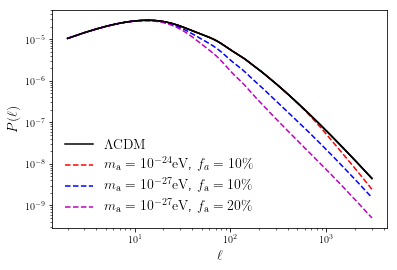

In [9]:
Pl = np.transpose([np.load('Data/pl_m%s.npy'%(i)) for i in range(1,12)],(0,1,5,2,3,4))
pl_test = np.transpose(Pl,(3,4,1,0,2,5))[0][0][2]
lgoal = np.arange(2,3000,1)

plt.loglog(lgoal,pl_test[10][0],label = r'$\Lambda {\rm CDM}$',color = 'k',alpha = 1)
# plt.loglog(lgoal,pl_test[3][4],label = r'$m_a = 10^{-27}$eV, $f_a = 10\%$',color = 'b',alpha = 1)
plt.loglog(lgoal,pl_test[8][4],label = r'$m_{\rm a} = 10^{-24}{\rm eV}$, $f_a = 10\%$',color = 'r',alpha = 1,linestyle  =  'dashed')
plt.loglog(lgoal,pl_test[10][0],color = 'k',alpha = 1)
plt.xlabel('$\ell$',size = 14)
plt.ylabel('$P(\ell)$',size = 14)
# plt.title('$P(\ell)$ Dependence on Axion Mass',size = 14)
plt.legend(frameon = False,fontsize = 14)
# plt.savefig('Pl_mass.pdf')

# plt.loglog(lgoal,pl_test[10][0],label = r'$\Lambda CDM$',color = 'k')
plt.loglog(lgoal,pl_test[3][4],label = r'$m_{\rm a} = 10^{-27}{\rm eV}$, $f_{\rm a} = 10\%$',color = 'b',linestyle  =  'dashed')
plt.loglog(lgoal,pl_test[3][8],label = r'$m_{\rm a} = 10^{-27}{\rm eV}$, $f_{\rm a} = 20\%$',color = 'm',linestyle  =  'dashed')
plt.loglog(lgoal,pl_test[10][0],color = 'k',alpha = 1)
plt.xlabel('$\ell$',size = 14)
plt.ylabel('$P(\ell)$',size = 14)
# plt.title('$P(\ell)$ Dependence on Axion Fraction',size = 14)
plt.legend(frameon = False,fontsize = 14)
# plt.savefig('Pl_fraction.pdf')

plt.savefig('Pl_axion_effect.pdf')
plt.show()
